# ARIMA MODELING ON EBAY DATA 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm

Getting the data

In [2]:
train_ebay = pd.read_csv("train_ebay.csv")
test_ebay = pd.read_csv("test_ebay.csv")

Merging the data as we just need the closing price for ARIMA prediction

In [3]:
ebay = [train_ebay , test_ebay]

for df in ebay:
    df.columns = ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']

ebay_data = pd.concat(ebay).reset_index(drop=True)


Data manipulation

In [4]:
ebay_data = ebay_data.sort_values("date").set_index("date")  #Sorting the dataset as per the date and setting date as the index

In [5]:
ebay_data.index =  pd.to_datetime(ebay_data.index)

In [6]:
ebay_data.head() #Overview

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,EBAY,23.719999,23.900000,23.619999,23.979998,22511600.0
2010-01-05,EBAY,23.790000,23.650000,23.500000,23.900000,26683100.0
2010-01-06,EBAY,23.629998,23.500000,23.440000,23.800000,26368600.0
2010-01-07,EBAY,23.490000,23.229998,23.169999,23.490000,25220000.0
2010-01-08,EBAY,23.190000,23.509999,23.100000,23.640000,30484000.0


In [7]:
#Resampling it monthwise indicating the starting date. mean() is used to get the mean closing price value accross the time period
Y_ebay = ebay_data["close"].resample('MS').mean() 

Visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

In [1]:
#Trend : if the values show any overall upward or downward trend or slope
#Seasonality : if the values repeat after a specific interval of time. Say the sales of colours increases around the Holi season. Hence there's a particular season or time when it's shows an upward trend.
#noise : no relations between the values and the time.

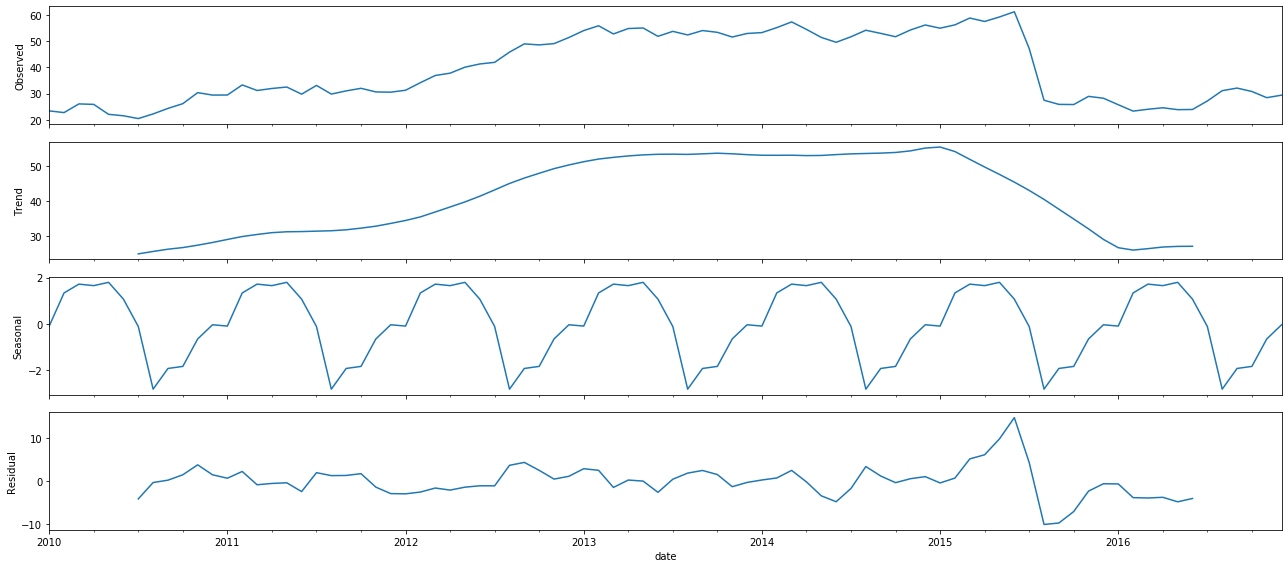

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Y_ebay , model='additive')
fig = decomposition.plot()
plt.show()

There's an obvious seasonality observed hence we will use SARIMA for our modeling

# Time series forecasting with ARIMA

__ARIMA which stands for Autoregressive Integrated Moving Average__

- ARIMA models are denoted with the notation ARIMA(p, d, q). </br>
- p for Auto regressive part as how many past values (p) our model is dependent on. </br>
- q for Moving Average part as how many past random error terms (q) our model is dependent on. </br>
- d for Integrated part as the number of times differencing is required to make it stationary.

In [33]:
#Setting the range of values for p,d and q
p = d = q = range(0, 2)

#Getting a list of possible cartesian products of (p,d,q) 
pdq = list(itertools.product(p, d, q))

#Setting the possible inputs for SARIMA
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Hyperparameter tuning to get all the possible values and their corresponding AIC scores. Storing the parameters that gives the best AIC score

In [34]:
def best_model():
    AIC = 1000
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(Y_ebay ,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit(maxiter=400)
                if results.aic < AIC:
                    AIC = results.aic
                    best_param = param
                    best_seasonal = param_seasonal
            
            except:
                continue   
    
    return best_param,best_seasonal,AIC

In [35]:
param , param_seasonal , AIC = best_model()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, AIC))

C:\Users\Shouvik\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:306.82743575620805


The above output suggests that SARIMAX(0, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 306.82. Therefore we should consider this to be optimal option.



__Fitting the ARIMA model__

In [36]:
mod = sm.tsa.statespace.SARIMAX(Y_ebay ,order=(0, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7258      0.098      7.379      0.000       0.533       0.919
ar.S.L12      -0.7000      0.244     -2.866      0.004      -1.179      -0.221
ma.S.L12      -0.3725      0.363     -1.027      0.304      -1.083       0.338
sigma2        10.7487      1.392      7.719      0.000       8.020      13.478


Diagnostics to investigate any unusual behavior

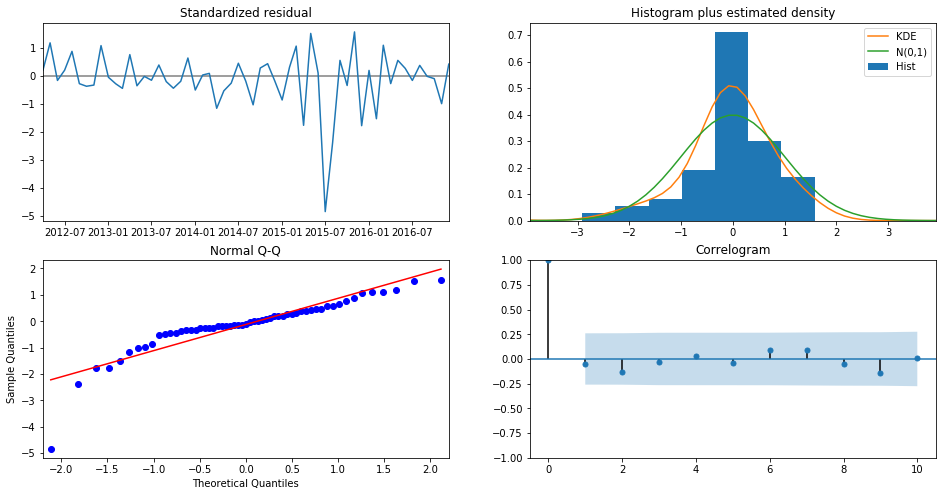

In [37]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- KDE plot that we got is similar to the normal distribution
- Quantile-Quantile plot also suggests it is nearly normally distributed

# Predicting the future values 

In [38]:
#Predicting the values starting fron 2016-01-01 to 2016-12-01
pred = results.get_prediction(start= pd.to_datetime('2016-01-01'), end = pd.to_datetime('2016-12-01') , dynamic=False)

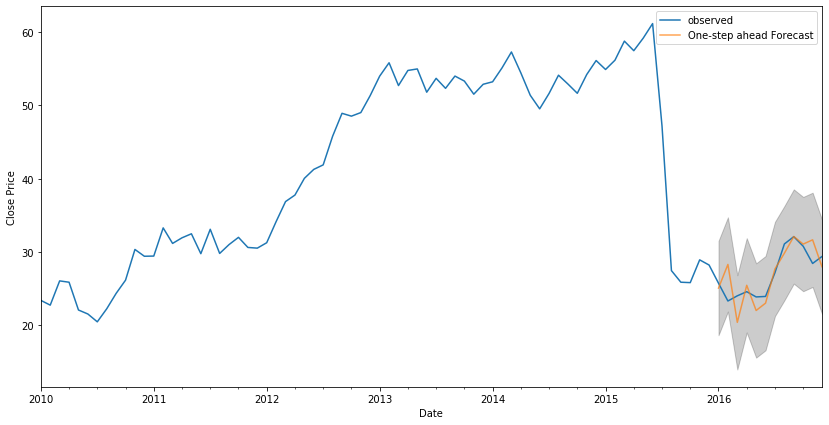

In [39]:
#Plotting the original closing price to predicted closing price graph

pred_ci = pred.conf_int()
ax = Y_ebay.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()
plt.show()

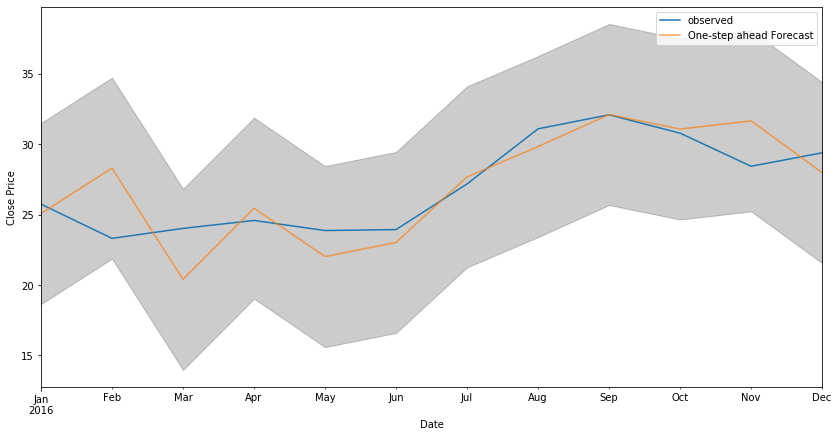

In [76]:
#Zooming on to the 2016 prediction graph
pred_ci = pred.conf_int()
ax = Y_ebay.tail(12).plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()
plt.show()

Comparing the results and getting the RMS value

In [40]:
y_pred = np.array(pred.predicted_mean)
y_actual = np.array(Y_ebay.tail(12))

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_actual, y_pred))
rms

2.1929242931323865

Plotting the future predictions ranging till 2022. Getting the Maximum, Mean and Minimum predicted value 

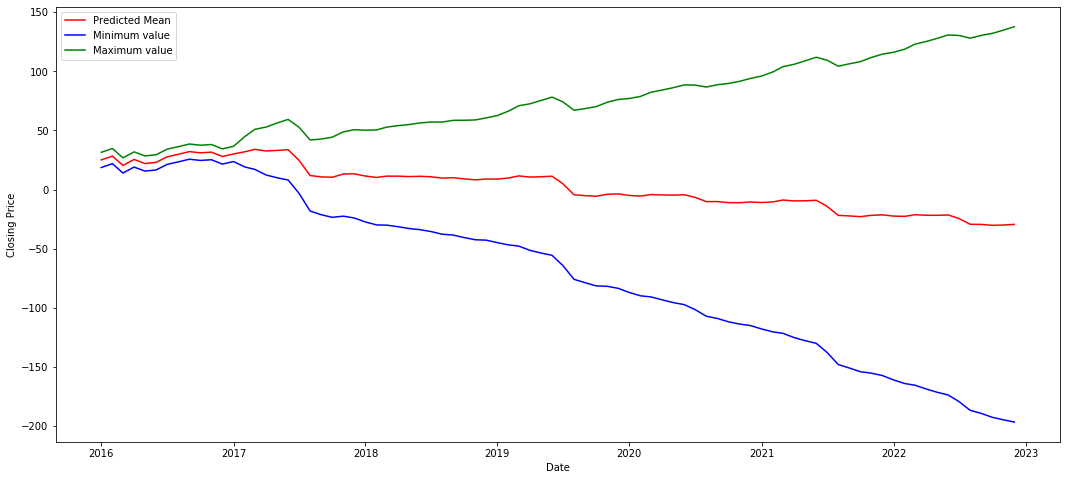

In [75]:
pred = results.get_prediction(start= pd.to_datetime('2016-01-01'), end = pd.to_datetime('2022-12-01') , dynamic=False)
pred_ci = pred.conf_int()
plt.plot(pred_ci.index, np.array(pred.predicted_mean),  color = 'red' , label = 'Predicted Mean')
plt.plot(pred_ci.index, np.array(pred_ci.iloc[:,0]),  color = 'blue' , label = 'Minimum value')
plt.plot(pred_ci.index, np.array(pred_ci.iloc[:,1]),  color = 'green' , label = 'Maximum value')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


__Conclusion__

Closing price seems to decrease indicating this stock to be a overvalued stock which might lose it's value in the future. hence this company could go bankrupt